In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-reviews/amazon_reviews.csv


In [2]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
labels = [  'Negative','Positive']

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud


In [4]:
import nltk
# nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


In [5]:
data = pd.read_csv('/kaggle/input/amazon-reviews/amazon_reviews.csv')
data.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.0,Four Stars,1406073600,2014-07-23,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.0,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.0,nothing to really say....,1356220800,2012-12-23,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.0,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.0,best deal around,1373673600,2013-07-13,513,0,0


In [6]:
data.dropna(inplace=True)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4913 entries, 1 to 4914
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviewerID      4913 non-null   object 
 1   asin            4913 non-null   object 
 2   reviewerName    4913 non-null   object 
 3   helpful         4913 non-null   object 
 4   reviewText      4913 non-null   object 
 5   overall         4913 non-null   float64
 6   summary         4913 non-null   object 
 7   unixReviewTime  4913 non-null   int64  
 8   reviewTime      4913 non-null   object 
 9   day_diff        4913 non-null   int64  
 10  helpful_yes     4913 non-null   int64  
 11  total_vote      4913 non-null   int64  
dtypes: float64(1), int64(4), object(7)
memory usage: 499.0+ KB


In [8]:
data['overall'].value_counts()

overall
5.0    3921
4.0     526
1.0     244
3.0     142
2.0      80
Name: count, dtype: int64

In [9]:
#1,2,3->negative(i.e 0)
data.loc[data['overall']<=3.0,'overall'] = 0

 
#4,5->positive(i.e 1)
data.loc[data['overall']>3.0,'overall'] = 1

In [10]:
data['overall'].value_counts()

overall
1.0    4447
0.0     466
Name: count, dtype: int64

In [11]:
stp_words=stopwords.words('english')
def clean_review(review):
  cleanreview=" ".join(word for word in review.split() if word not in stp_words)
  return cleanreview
 
data['reviewText']=data['reviewText'].apply(clean_review)
data['reviewText']=data['reviewText'].str.lower()

In [12]:
data.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","purchased device, worked advertised. you never...",1.0,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",works expected. i sprung higher capacity. i th...,1.0,nothing to really say....,1356220800,2012-12-23,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",this think worked great.had diff. bran 64gb ca...,1.0,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","bought retail packaging, arrived legit, orange...",1.0,best deal around,1373673600,2013-07-13,513,0,0
5,A2IDCSC6NVONIZ,B007WTAJTO,2Cents!,"[0, 0]",it's mini storage. it anything else supposed t...,1.0,Not a lot to really be said,1367193600,2013-04-29,588,0,0


In [13]:
data['overall'].value_counts()

overall
1.0    4447
0.0     466
Name: count, dtype: int64

In [14]:
cv = TfidfVectorizer(max_features=2500)
X = cv.fit_transform(data['reviewText'] ).toarray()

In [15]:
from sklearn.model_selection import train_test_split
xx_train ,xx_test,yy_train,yy_test=train_test_split(data['reviewText'],data['overall'],
                                                test_size=0.25 ,
                                                random_state=42)

In [16]:
from sklearn.model_selection import train_test_split
x_train ,x_test,y_train,y_test=train_test_split(X,data['overall'],
                                                test_size=0.25 ,
                                                random_state=42)

# Classification with logistic function

In [17]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

model=LogisticRegression()
 
#Model fitting
model.fit(x_train,y_train)
 
#testing the model
pred=model.predict(x_test)
 
#model accuracy
score=metrics.accuracy_score(y_test,pred)
print(score)

0.9104963384865744


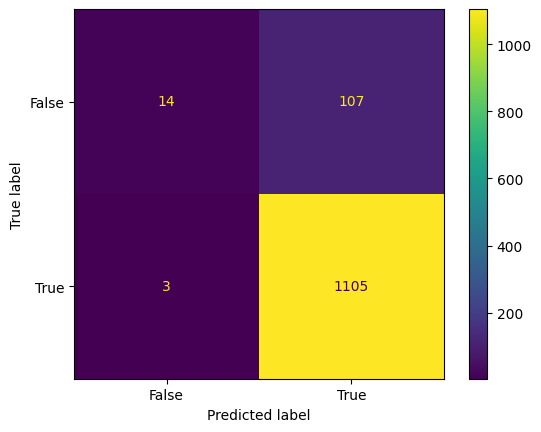

In [18]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_test,pred)
 
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm,
                                            display_labels = [False, True])
 
cm_display.plot()
plt.show()

# Support Vector Machine

In [20]:
from sklearn.metrics import accuracy_score, classification_report

Training accuracy Score    :  0.9842562432138979
Testing accuracy Score :  0.9170056956875509
              precision    recall  f1-score   support

         0.0       0.19      0.85      0.31        27
         1.0       1.00      0.92      0.96      1202

    accuracy                           0.92      1229
   macro avg       0.59      0.89      0.63      1229
weighted avg       0.98      0.92      0.94      1229



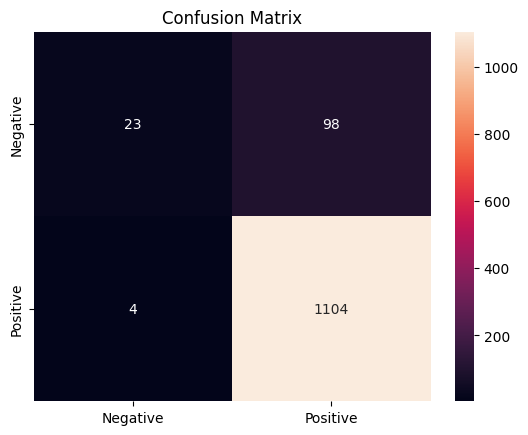

In [21]:
from sklearn.svm import SVC

svc = SVC()

svc.fit(x_train, y_train)

svc_prediction = svc.predict(x_test)
svc_accuracy = metrics.accuracy_score(y_test,svc_prediction)
print("Training accuracy Score    : ",svc.score(x_train,y_train))
print("Testing accuracy Score : ",svc_accuracy )
print(classification_report(svc_prediction,y_test))
#Confustion matrix
confm = confusion_matrix(y_test, svc_prediction)
cm= pd.DataFrame(confm, index = [i for i in labels],
                columns = [i for i in labels])

# plt.figure(figsize = (8,6))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.show()

# k-NN model

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier


Accuracy: 0.90
              precision    recall  f1-score   support

         0.0       0.45      0.14      0.21       121
         1.0       0.91      0.98      0.95      1108

    accuracy                           0.90      1229
   macro avg       0.68      0.56      0.58      1229
weighted avg       0.87      0.90      0.87      1229



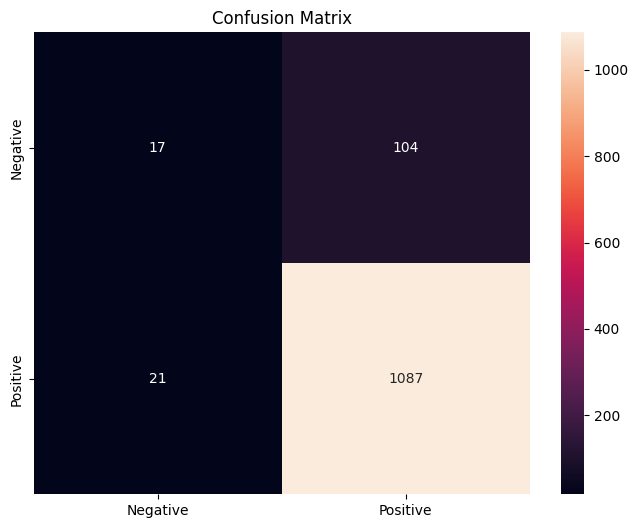

In [23]:
# Convert text data to numerical features using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=100)  # You can adjust max_features as needed
X_train_tfidf = tfidf_vectorizer.fit_transform(xx_train)
X_test_tfidf = tfidf_vectorizer.transform(xx_test)

# Initialize and train the KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors (k) as needed
knn_model.fit(X_train_tfidf, yy_train)

# Make predictions on the test set
y_pred = knn_model.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(yy_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Display classification report
print(classification_report(yy_test, y_pred))
#Confustion matrix
confm = confusion_matrix(yy_test, y_pred)
cm= pd.DataFrame(confm, index = [i for i in labels],
                columns = [i for i in labels])

plt.figure(figsize = (8,6))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.show()

# Classification with linear function

In [24]:

from sklearn.linear_model import LinearRegression

Accuracy: 0.85
              precision    recall  f1-score   support

         0.0       0.33      0.54      0.41       121
         1.0       0.95      0.88      0.91      1108

    accuracy                           0.85      1229
   macro avg       0.64      0.71      0.66      1229
weighted avg       0.88      0.85      0.86      1229



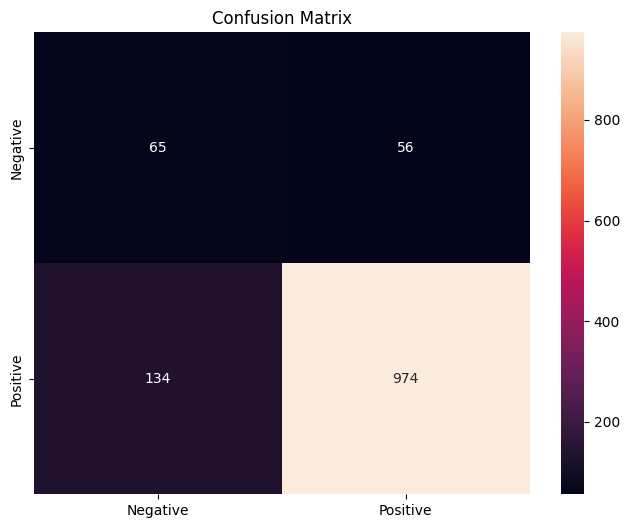

In [25]:
# Initialize and train the Linear Regression model
linear_model = LinearRegression()
linear_model.fit(x_train, y_train)

# Make predictions on the test set
y_pred = (linear_model.predict(x_test) > 0.5).astype(int)

# Convert predicted probabilities to binary predictions using a threshold (0.5 in this case)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Display classification report
print(classification_report(y_test, y_pred))
#Confustion matrix
confm = confusion_matrix(y_test, y_pred)
cm= pd.DataFrame(confm, index = [i for i in labels],
                columns = [i for i in labels])

plt.figure(figsize = (8,6))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.show()

# Stochastic Gradient Descent Classifier

Training accuracy Score    :  0.9842562432138979
Validation accuracy Score :  0.9324654190398698
              precision    recall  f1-score   support

         0.0       0.44      0.78      0.56        68
         1.0       0.99      0.94      0.96      1161

    accuracy                           0.93      1229
   macro avg       0.71      0.86      0.76      1229
weighted avg       0.96      0.93      0.94      1229



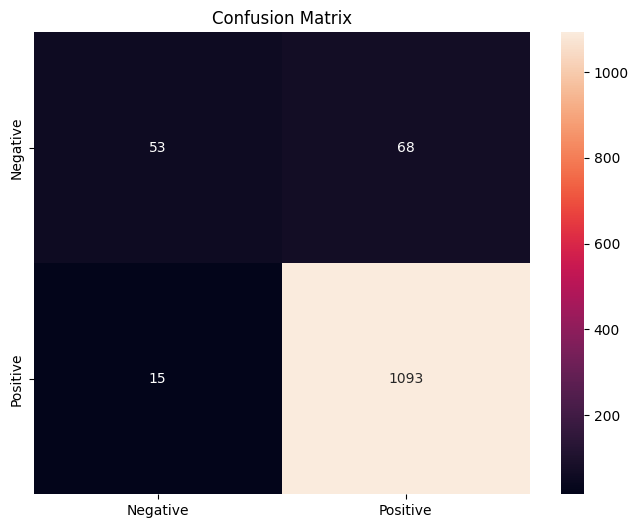

In [26]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss = 'hinge', penalty = 'l2', random_state=0)

sgd_clf.fit(x_train,y_train)

sgd_prediction = sgd_clf.predict(x_test)
sgd_accuracy = accuracy_score(y_test,sgd_prediction)
print("Training accuracy Score    : ",sgd_clf.score(x_train,y_train))
print("Validation accuracy Score : ",sgd_accuracy )
print(classification_report(sgd_prediction,y_test))
#Confustion matrix
confm = confusion_matrix(y_test, sgd_prediction)
cm= pd.DataFrame(confm, index = [i for i in labels],
                columns = [i for i in labels])

plt.figure(figsize = (8,6))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.show()

# Batch Gradient Descent Classifier

In [27]:
# import numpy as np

class BatchGradientDescentClassifier:
    def __init__(self, learning_rate=0.01, num_epochs=1000):
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.weights = None
        self.bias = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        # Add a column of ones to the input matrix for the bias term
        X = np.c_[np.ones((X.shape[0], 1)), X]

        # Initialize weights and bias
        self.weights = np.zeros(X.shape[1])
        self.bias = 0

        for epoch in range(self.num_epochs):
            # Compute the predicted values
            z = np.dot(X, self.weights) + self.bias
            y_pred = self.sigmoid(z)

            # Compute the gradient of the cost function
            gradient_weights = np.dot(X.T, (y_pred - y)) / len(y)
            gradient_bias = np.sum(y_pred - y) / len(y)

            # Update weights and bias
            self.weights -= self.learning_rate * gradient_weights
            self.bias -= self.learning_rate * gradient_bias

    def predict(self, X):
        # Add a column of ones to the input matrix for the bias term
        X = np.c_[np.ones((X.shape[0], 1)), X]

        # Compute the predicted values
        z = np.dot(X, self.weights) + self.bias
        y_pred = self.sigmoid(z)

        # Round the predicted values to 0 or 1
        y_pred = np.round(y_pred)

        return y_pred

# Example usage:
# Assume X_train and y_train are your training data and labels
# Assume X_test is your test data

# Create and train the model
model = BatchGradientDescentClassifier(learning_rate=0.01, num_epochs=1000)
model.fit(x_train, y_train)

# Make predictions on the test data
predictions = model.predict(x_test)


In [28]:
print(classification_report(predictions,y_test))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.90      0.95      1229

    accuracy                           0.90      1229
   macro avg       0.50      0.45      0.47      1229
weighted avg       1.00      0.90      0.95      1229



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


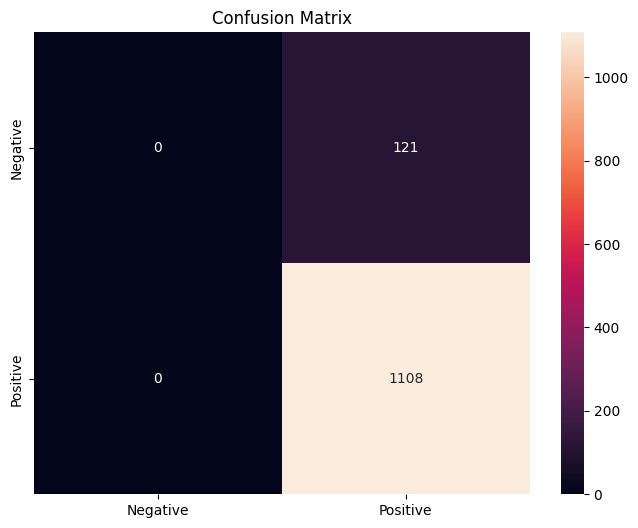

In [29]:
#Confustion matrix
confm = confusion_matrix(y_test, predictions)
cm= pd.DataFrame(confm, index = [i for i in labels],
                columns = [i for i in labels])

plt.figure(figsize = (8,6))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.show()

# Locally Weighted Regression

In [30]:
# Necessary imports
import numpy as np
from ipywidgets import interact
from bokeh.plotting import figure, show, output_notebook
from bokeh.layouts import gridplot
%matplotlib inline
output_notebook()

# function to perform locally weighted linear regression
def local_weighted_regression(x0, X, Y, tau):
    # add bias term
    x0 = np.r_[1, x0]
    X = np.c_[np.ones(len(X)), X]

    # fit model: normal equations with kernel
    xw = X.T * weights_calculate(x0, X, tau)
    theta = np.linalg.pinv(xw @ X) @ xw @ Y
    # "@" is used to predict value
    return x0 @ theta

# function to perform weight calculation
def weights_calculate(x0, X, tau):
    return np.exp(np.sum((X - x0) ** 2, axis=1) / (-2 * (tau ** 2)))

# plot locally weighted regression for different bandwidth values
def plot_lwr(tau):
    # prediction
    domain = np.linspace(-3, 3, num=300)
    prediction = [local_weighted_regression(x0, X, Y, tau) for x0 in domain]

    plot = figure(width=400, height=400)
    plot.title.text = 'tau=%g' % tau
    plot.scatter(X, Y, alpha=.3)
    plot.line(domain, prediction, line_width=2, color='red')

    return plot

# define distribution
n = 1000

# generate dataset
X = np.linspace(-3, 3, num=n)
Y = np.abs(X ** 3 - 1)

# jitter X
X += np.random.normal(scale=.1, size=n)

# show the plots for different values of Tau
show(gridplot([
    [plot_lwr(10.), plot_lwr(1.)],
    [plot_lwr(0.1), plot_lwr(0.01)]
]))


Loading BokehJS ...